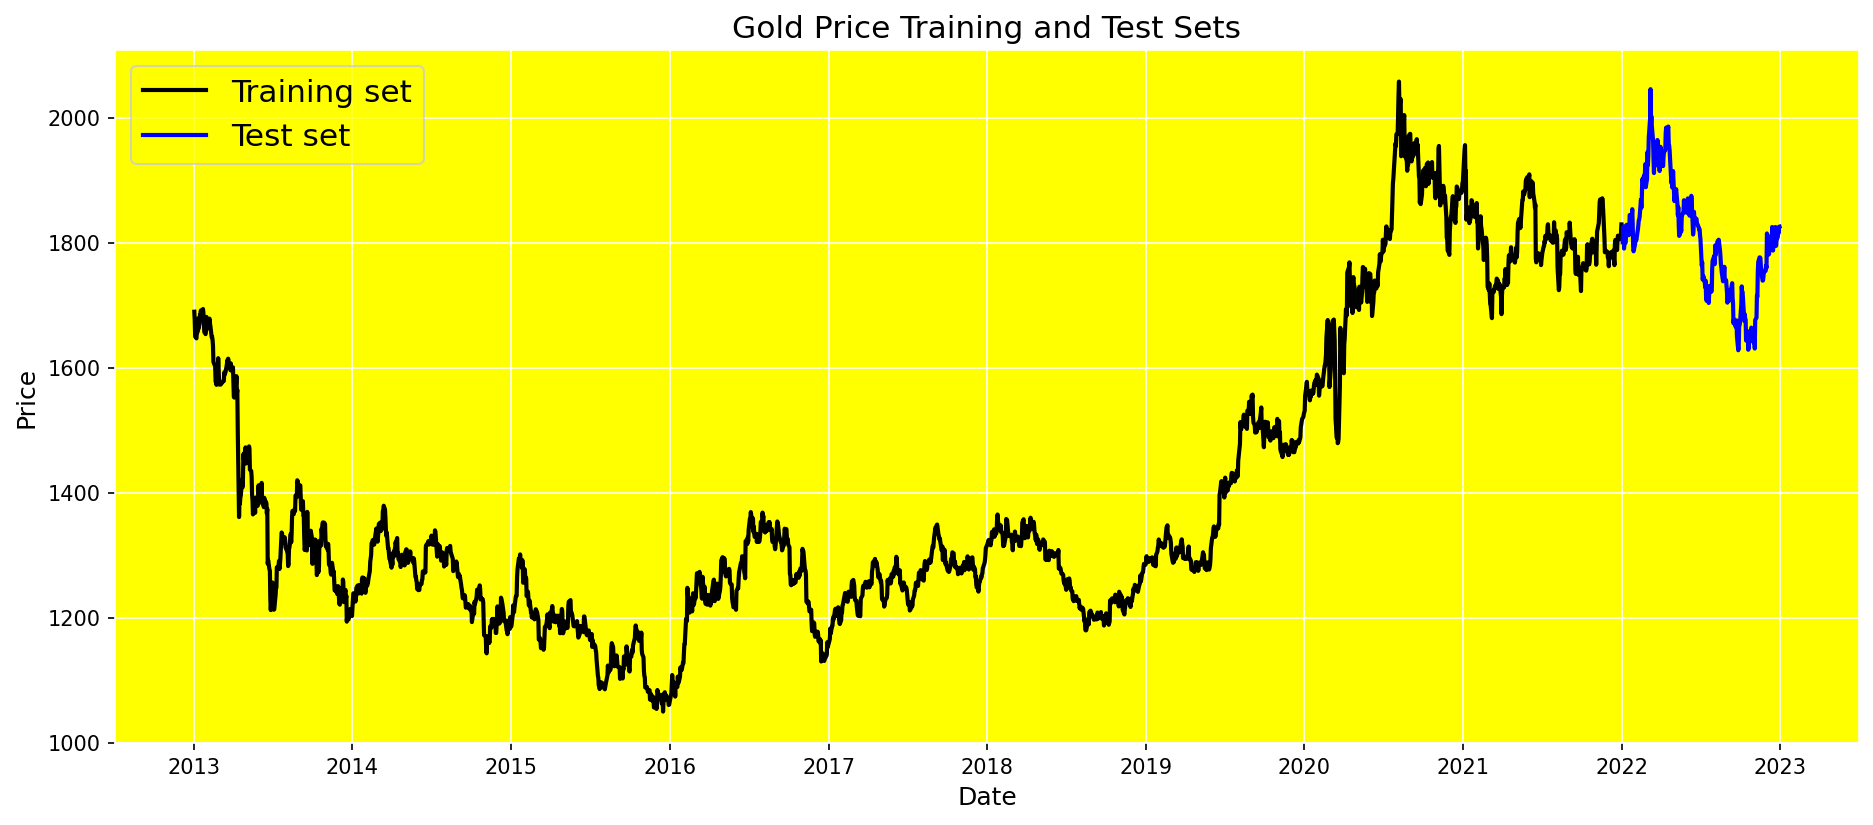

X_train Shape:  (2263, 60, 1)
y_train Shape:  (2263, 1)
X_test Shape:   (260, 60, 1)
y_test Shape:   (260, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 60, 1)]              0         []                            
                                                                                                  
 multi_head_attention_1 (Mu  (None, 60, 1)                29        ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 dropout_1 (Dropout)         (None, 60, 1)                0         ['multi_head_attention_1[0][0]
                                                                    ']           

ValueError: y_true and y_pred have different number of output (1!=60)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

df = pd.read_csv('/content/Gold Price (2013-2023).csv')

df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)

df.reset_index(drop=True, inplace=True)

NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

df.head()
df.duplicated().sum()
df.isnull().sum().sum()

fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y': 0.95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

test_size = df[df.Date.dt.year == 2022].shape[0]
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes', edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1, 1))

window_size = 60
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1, 1))
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

test_data = df.Price[-test_size - 60:]
test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i - 60:i, 0])
    y_test.append(test_data[i, 0])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)


def define_model(window_size):
    input1 = Input(shape=(window_size, 1))

    # Replace LSTM layers with Transformer layers
    transformer_layer = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2, dropout=0.2)
    x = transformer_layer(input1, input1)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=dnn_output)
    model.compile(loss='mean_squared_error', optimizer=Nadam())
    model.summary()

    return model


# Assuming you have defined X_train, y_train, X_test, y_test, and scaler
window_size = X_train.shape[1]  # Assuming the window size is the same for training and testing data
model = define_model(window_size)
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

y_pred = model.predict(X_test)
y_test = np.squeeze(y_test)
y_pred = np.squeeze(y_pred)
y_test = np.squeeze(y_test)
y_pred = np.squeeze(y_pred)

MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes', edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()
